In [1]:
import h5py
import matplotlib.pyplot as plt
import pathlib
import py4DSTEM
import pyprismatic
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy import signal

sns.set_style("ticks")

## Simulation

In [2]:
dfs_folder = "outputs/large_defocus_stem/"
pathlib.Path(dfs_folder).mkdir(parents=True, exist_ok=True) 

In [3]:
#output paths
dfs_m = dfs_folder+"large_defocus_multislice.h5" 
dfs_p = dfs_folder+"large_defocus_prism.h5"
dfs_p_rf = dfs_folder+"large_defocus_prism_refocus.h5"

#input paths
fp_au = "structure_files/Au_NP_tilted.xyz" #file path to a gold nanoparticle structure oriented with 001 parallel to the beam direction
fp_probe_pos = "param_files/probe_pos" #file path to probe positions; 9 probe positions in grid at based around NP

In [ ]:
dfs_meta = pyprismatic.Metadata()
dfs_meta.filenameAtoms = fp_au
dfs_meta.filenameOutput = dfs_m
dfs_meta.probes_file = fp_probe_pos

dfs_meta.E0 = 200
dfs_meta.realspacePixelSize = 0.1
dfs_meta.probeSemiangle = 21
dfs_meta.probeDefocus_min = -2525
dfs_meta.probeDefocus_max = 2475
dfs_meta.probeDefocus_step = 50

dfs_meta.potential3D = False
dfs_meta.save3DOutput = True
dfs_meta.save4DOutput = True
dfs_meta.savePotentialSlices = True
dfs_meta.includeThermalEffects = False

In [ ]:
dfs_meta.algorithm = "m"
if not pathlib.Path(dfs_meta.filenameOutput).exists():
    dfs_meta.go()

In [ ]:
dfs_meta.filenameOutput = dfs_p
dfs_meta.algorithm = 'p'
dfs_meta.interpolationFactor = 2
if not pathlib.Path(dfs_meta.filenameOutput).exists():
    dfs_meta.go()

In [ ]:
dfs_meta.filenameOutput = dfs_p_rf
dfs_meta.matrixRefocus = True
dfs_meta.numGPUs=0 
if not pathlib.Path(dfs_meta.filenameOutput).exists():
    dfs_meta.go()

## Plotting

In [ ]:
def get_vd_from_cbed(cbed, q, bs):
    max_angle = np.floor(q[q.shape[0]-1,q.shape[1]//2])
    vd = np.zeros(int(max_angle/bs))
    for i in range(vd.shape[0]):
        b = i*bs
        vd[i] = np.sum(cbed*np.logical_and(q > b-bs/2, q <= b+bs/2))
        
    return vd

def get_vd_from_cbed_stack(cbed_stack, q, bs):
    max_angle = np.floor(q[q.shape[0]-1,q.shape[1]//2])
    ss = cbed_stack.shape
    vd_shape = (ss[0], ss[1], int(max_angle/bs), ss[-1])
    vd = np.zeros(vd_shape)
    for i in range(vd.shape[2]):
        b = i*bs
        mask = np.logical_and(q > b-bs/2, q <= b+bs/2)[np.newaxis, np.newaxis, :, :, np.newaxis]
        vd[:,:,i,:] = np.sum(cbed_stack*mask, axis=(2,3))
        
    return vd

def load_cbed_stack(fp, N):
    # read first one and get dims
    cbed = py4DSTEM.io.read(fp, data_id="CBED_array_depth0000_df0000")
    cbed_stack = np.zeros((list(cbed.data.shape)+[N]))
    for i in range(N):
        id_str = "CBED_array_depth0000_df%04i" % i
        cbed_stack[:,:,:,:,i] = py4DSTEM.io.read(fp, data_id=id_str).data
    
    return cbed_stack

def gaussian_kernel(sigma, bin_size, N):
    x = np.arange(-N, N+1)*bin_size
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-0.5)*(x/sigma)**2.0)

def calc_error(ref, test):
    return np.abs(test-ref)

def bin_img(img, f):
    """
    Takes an image with shape (Nx, Ny)
    Expects f to be an integer; orig. shape must be divisible by f
    Returns an array with shape (Nx/f, Ny/f)
    returned array is averaged over local pixels, such that np.sum([0:f, 0:f])/(f**2.0) -> [0,0],
    mean of array is maintained by extreme values are not
    """
    Nx = img.shape[0]
    Ny = img.shape[1]
    assert(not Nx%f), "Array is not binnable by f"
    img = img.reshape(int(Nx/f), f, Ny).sum(axis=(1))
    return img

In [ ]:
ppot_df = py4DSTEM.io.read(dfs_m, data_id="ppotential_fp0000")

cbed_m_stack = load_cbed_stack(dfs_m, 101)
cbed_p_stack = load_cbed_stack(dfs_p, 101)
cbed_p_rf_stack = load_cbed_stack(dfs_p_rf, 101)

In [ ]:
### get necessary dimension arrays
f_dfs_m = h5py.File(dfs_m, mode='r')
df_vals = np.copy(f_dfs_m['4DSTEM_simulation']['data']['supergroups']['vd_CC_series']['sgdim1'])
qpx_m_arr = np.copy(f_dfs_m['4DSTEM_simulation']['data']['datacubes']['CBED_array_depth0000_df0000']['dim3'])
qpy_m_arr = np.copy(f_dfs_m['4DSTEM_simulation']['data']['datacubes']['CBED_array_depth0000_df0000']['dim4'])
qpx_m = qpx_m_arr[np.where(qpx_m_arr==0.0)[0]+1][0]
f_dfs_m.close()

f_dfs_p = h5py.File(dfs_p, mode='r')
qpx_p_arr = np.copy(f_dfs_p['4DSTEM_simulation']['data']['datacubes']['CBED_array_depth0000_df0000']['dim3'])
qpy_p_arr = np.copy(f_dfs_p['4DSTEM_simulation']['data']['datacubes']['CBED_array_depth0000_df0000']['dim4'])
qpx_p = qpx_p_arr[np.where(qpx_p_arr==0.0)[0]+1][0]
f_dfs_p.close()

w_lambda = pyprismatic.process.get_lambda(dfs_m)

In [ ]:
qxa_m, qya_m = np.meshgrid(qpx_m_arr, qpy_m_arr)
qxa_p, qya_p = np.meshgrid(qpx_p_arr, qpy_p_arr)

q_m = np.sqrt(qxa_m**2.0 + qya_m**2.0)*w_lambda*1000 #in units of mrad
q_p = np.fft.fftshift(np.sqrt(qxa_p**2.0 + qya_p**2.0))*w_lambda*1000

In [ ]:
bin_size = 0.25
vd_m_stack = get_vd_from_cbed_stack(cbed_m_stack, q_m, bin_size)
vd_p_stack = get_vd_from_cbed_stack(cbed_p_stack, q_p, bin_size)
vd_p_rf_stack = get_vd_from_cbed_stack(cbed_p_rf_stack, q_p, bin_size)

In [ ]:
N = int(np.round(1/bin_size))
sigma = 1.0
kernel = gaussian_kernel(sigma,bin_size,3*N)[np.newaxis, np.newaxis, :, np.newaxis]
kernel /= np.sum(kernel)

vd_m = signal.convolve(vd_m_stack, kernel, mode="same")
vd_p = signal.convolve(vd_p_stack, kernel, mode="same")
vd_p_rf = signal.convolve(vd_p_rf_stack, kernel, mode="same")

In [17]:
#construct images
ppot_im = np.sum(ppot_df.data, axis=2)

#CBED pictures are a mosaic over defocus
#half-half split
si = 1
ei = 3
tot = 4

ms = cbed_m_df_mean.shape[2:] 
ps = cbed_p_df_mean.shape[2:]
mso = tuple((ei*x//tot-si*x//tot) for x in cbed_m_df_mean.shape[2:])
pso = tuple((ei*x//tot-si*x//tot) for x in cbed_p_df_mean.shape[2:])
cbed_m_hh_center = np.zeros(mso)
cbed_p_hh_center = np.zeros(pso)
cbed_p_rf_hh_center = np.zeros(pso)

cbed_m_hh_side = np.zeros(mso)
cbed_p_hh_side = np.zeros(pso)
cbed_p_rf_hh_side = np.zeros(pso)

cbed_m_hh_center[:,:mso[1]//2] = cbed_m_df_mean[4,0, si*ms[0]//tot:ei*ms[0]//tot, si*ms[1]//tot:ms[1]//2]
cbed_m_hh_center[:,mso[1]//2:]  = cbed_m_df_min[4,0, si*ms[0]//tot:ei*ms[0]//tot, ms[1]//2:ei*ms[1]//tot]
cbed_p_hh_center[:,:pso[1]//2] = cbed_p_df_mean[4,0, si*ps[0]//tot:ei*ps[0]//tot, si*ps[1]//tot:ps[1]//2]
cbed_p_hh_center[:,pso[1]//2:]  = cbed_p_df_min[4,0, si*ps[0]//tot:ei*ps[0]//tot, ps[1]//2:ei*ps[1]//tot]
cbed_p_rf_hh_center[:,:pso[1]//2] = cbed_p_rf_df_mean[4,0, si*ps[0]//tot:ei*ps[0]//tot, si*ps[1]//tot:ps[1]//2]
cbed_p_rf_hh_center[:,pso[1]//2:]  = cbed_p_rf_df_min[4,0, si*ps[0]//tot:ei*ps[0]//tot, ps[1]//2:ei*ps[1]//tot]

cbed_m_hh_side[:,:mso[1]//2] = cbed_m_df_mean[1,0, si*ms[0]//tot:ei*ms[0]//tot, si*ms[1]//tot:ms[1]//2]
cbed_m_hh_side[:,mso[1]//2:]  = cbed_m_df_min[1,0, si*ms[0]//tot:ei*ms[0]//tot, ms[1]//2:ei*ms[1]//tot]
cbed_p_hh_side[:,:pso[1]//2] = cbed_p_df_mean[1,0, si*ps[0]//tot:ei*ps[0]//tot, si*ps[1]//tot:ps[1]//2]
cbed_p_hh_side[:,pso[1]//2:]  = cbed_p_df_min[1,0, si*ps[0]//tot:ei*ps[0]//tot, ps[1]//2:ei*ps[1]//tot]
cbed_p_rf_hh_side[:,:pso[1]//2] = cbed_p_rf_df_mean[1,0, si*ps[0]//tot:ei*ps[0]//tot, si*ps[1]//tot:ps[1]//2]
cbed_p_rf_hh_side[:,pso[1]//2:]  = cbed_p_rf_df_min[1,0, si*ps[0]//tot:ei*ps[0]//tot, ps[1]//2:ei*ps[1]//tot]

#heat maps
heat_map_center = bin_img(100*calc_error(baseline_4, prism_4), int(1/bin_size))
heat_map_center_rf = bin_img(100*calc_error(baseline_4, prism_rf_4), int(1/bin_size))
heat_map_side = bin_img(100*calc_error(baseline_1, prism_1), int(1/bin_size))
heat_map_side_rf = bin_img(100*calc_error(baseline_1, prism_rf_1), int(1/bin_size))

In [18]:
# scale bar data
ppot_dim = 70.0 #angstrom unit cell
r_pix = ppot_dim / ppot_im.shape[0]
rs_len = 25.0/r_pix
qs_len_m = 1.0/qpx_m
qs_len_p = 1.0/qpx_p

[None, None, None, None]

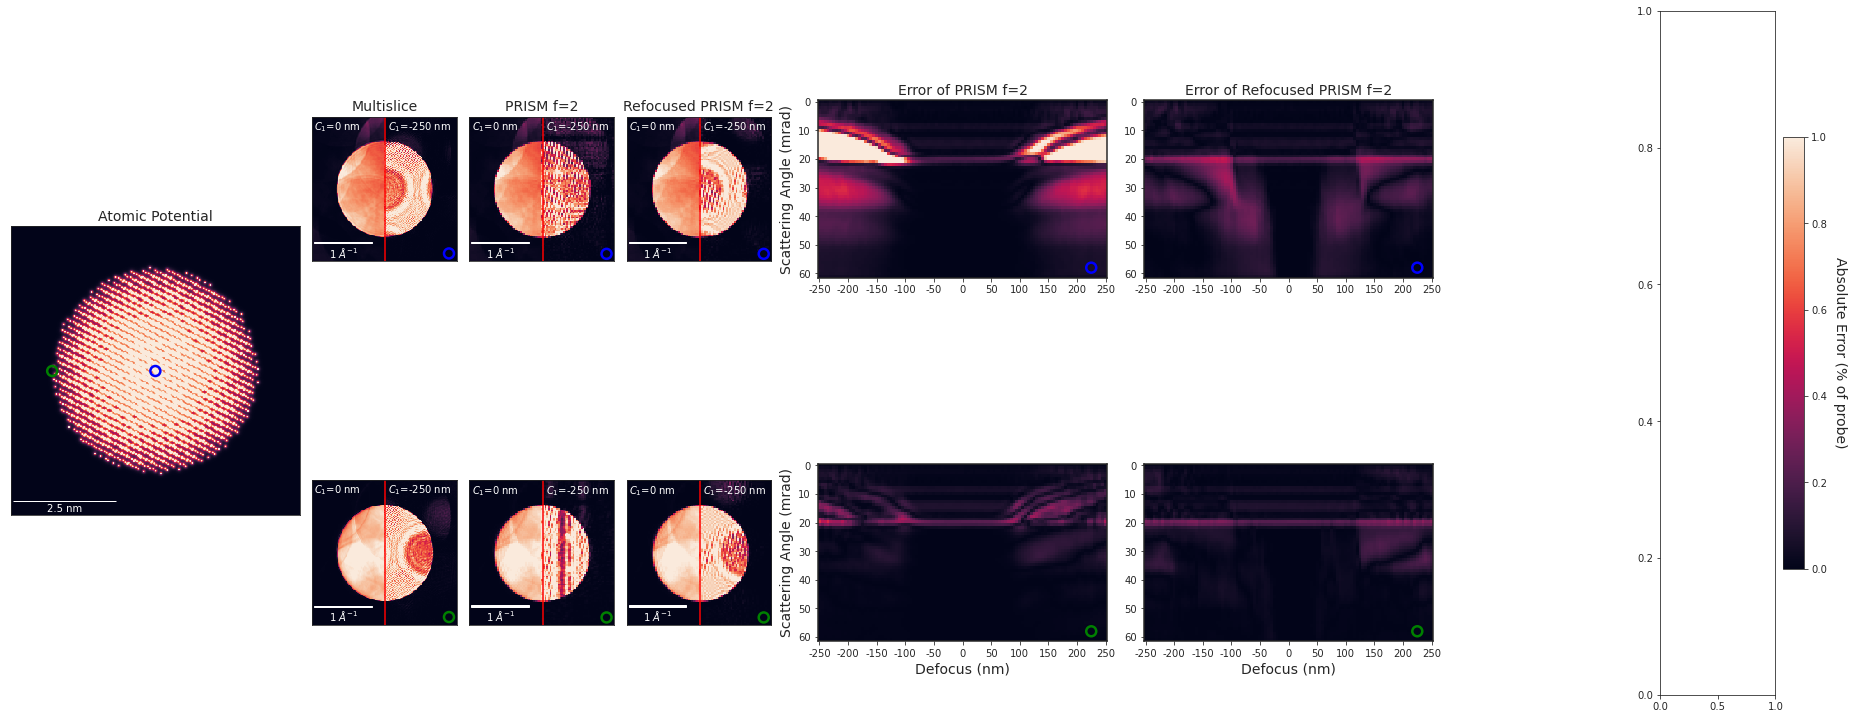

In [19]:
f = plt.figure(constrained_layout=True, figsize=(20,10))

gs = f.add_gridspec(2,9)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes. 
f_im00 = f.add_subplot(gs[:2,:2])
f_im02 = f.add_subplot(gs[0,2])
f_im03 = f.add_subplot(gs[0,3])
f_im04 = f.add_subplot(gs[0,4])

f_im12 = f.add_subplot(gs[1,2])
f_im13 = f.add_subplot(gs[1,3])
f_im14 = f.add_subplot(gs[1,4])

f_im00.matshow(ppot_im, vmin=0, vmax=1e3)

f_im02.matshow(cbed_m_hh_center, vmin=0, vmax=1e-4)
f_im03.matshow(cbed_p_hh_center, vmin=0, vmax=4e-4)
f_im04.matshow(cbed_p_rf_hh_center, vmin=0, vmax=4e-4)

f_im12.matshow(cbed_m_hh_side, vmin=0, vmax=1e-4)
f_im13.matshow(cbed_p_hh_side, vmin=0, vmax=4e-4)
f_im14.matshow(cbed_p_rf_hh_side, vmin=0, vmax=4e-4)

f_im00.scatter((10/70)*ppot_im.shape[0], (35/70)*ppot_im.shape[0], marker="o", facecolors="none", color="green", s=100, linewidths=2.5)
f_im00.scatter((35/70)*ppot_im.shape[0], (35/70)*ppot_im.shape[0], marker="o", facecolors="none", color="blue", s=100, linewidths=2.5)

f_im02.scatter(mso[0]-10, mso[1]-10, marker="o", facecolors="none", color="blue", s=100, linewidths=2.5)
f_im03.scatter(pso[0]-5, pso[1]-5, marker="o", facecolors="none", color="blue", s=100, linewidths=2.5)
f_im04.scatter(pso[0]-5, pso[1]-5, marker="o", facecolors="none", color="blue", s=100, linewidths=2.5)

f_im12.scatter(mso[0]-10, mso[1]-10, marker="o", facecolors="none", color="green", s=100, linewidths=2.5)
f_im13.scatter(pso[0]-5, pso[1]-5, marker="o", facecolors="none", color="green", s=100, linewidths=2.5)
f_im14.scatter(pso[0]-5, pso[1]-5, marker="o", facecolors="none", color="green", s=100, linewidths=2.5)

f_im02.text(2,15,"$C_1$=0 nm", color="white")
f_im02.text(92,15,"$C_1$=-250 nm", color="white")
f_im03.text(1,7.5,"$C_1$=0 nm", color="white")
f_im03.text(46,7.5,"$C_1$=-250 nm", color="white")
f_im04.text(1,7.5,"$C_1$=0 nm", color="white")
f_im04.text(46,7.5,"$C_1$=-250 nm", color="white")

f_im12.text(2,15,"$C_1$=0 nm", color="white")
f_im12.text(92,15,"$C_1$=-250 nm", color="white")
f_im13.text(1,7.5,"$C_1$=0 nm", color="white")
f_im13.text(46,7.5,"$C_1$=-250 nm", color="white")
f_im14.text(1,7.5,"$C_1$=0 nm", color="white")
f_im14.text(46,7.5,"$C_1$=-250 nm", color="white")


rs = AnchoredSizeBar(f_im00.transData,
                           rs_len, '2.5 nm', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

qs_m02 = AnchoredSizeBar(f_im02.transData,
                           qs_len_m, '1 $\AA^{-1}$', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

qs_p03 = AnchoredSizeBar(f_im03.transData,
                           qs_len_p, '1 $\AA^{-1}$', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

qs_p04 = AnchoredSizeBar(f_im04.transData,
                           qs_len_p, '1 $\AA^{-1}$', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

qs_m12 = AnchoredSizeBar(f_im12.transData,
                           qs_len_m, '1 $\AA^{-1}$', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

qs_p13 = AnchoredSizeBar(f_im13.transData,
                           qs_len_p, '1 $\AA^{-1}$', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

qs_p14 = AnchoredSizeBar(f_im14.transData,
                           qs_len_p, '1 $\AA^{-1}$', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

f_im00.add_artist(rs)
f_im02.add_artist(qs_m02)
f_im03.add_artist(qs_p03)
f_im04.add_artist(qs_p04)

f_im12.add_artist(qs_m12)
f_im13.add_artist(qs_p13)
f_im14.add_artist(qs_p14)

f_im02.axvline(mso[1]//2, color="red")
f_im03.axvline(pso[1]//2, color="red")
f_im04.axvline(pso[1]//2, color="red")

f_im12.axvline(mso[1]//2, color="red")
f_im13.axvline(pso[1]//2, color="red")
f_im14.axvline(pso[1]//2, color="red")

f_im00.set_title("Atomic Potential", fontsize=14)
f_im02.set_title("Multislice", fontsize=14)
f_im03.set_title("PRISM f=2", fontsize=14)
f_im04.set_title("Refocused PRISM f=2", fontsize=14)

f_im00.set_xticks([])
f_im00.set_yticks([])
f_im02.set_xticks([])
f_im02.set_yticks([])
f_im03.set_xticks([])
f_im03.set_yticks([])
f_im04.set_xticks([])
f_im04.set_yticks([])

f_im12.set_xticks([])
f_im12.set_yticks([])
f_im13.set_xticks([])
f_im13.set_yticks([])
f_im14.set_xticks([])
f_im14.set_yticks([])

xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
xtick_vals = [str(int((x+25)/10)) for x in df_vals[xticks]]

c_lims = [0, 1.0]
f_ax05 = f.add_subplot(gs[0,5:7])
cim05 = f_ax05.matshow(heat_map_center)
cim05.set_clim(c_lims)
f_ax05.set_ylabel("Scattering Angle (mrad)", fontsize=14)
f_ax05.set_title("Error of PRISM f=2", fontsize=14)
f_ax05.xaxis.set_ticks_position("bottom")
f_ax05.set_xticks(xticks)
f_ax05.set_xticklabels(xtick_vals)

f_ax07 = f.add_subplot(gs[0,7:])
cim07 = f_ax07.matshow(heat_map_center_rf)
cim07.set_clim(c_lims)
f_ax07.set_title("Error of Refocused PRISM f=2", fontsize=14)
f_ax07.xaxis.set_ticks_position("bottom")
f_ax07.set_xticks(xticks)
f_ax07.set_xticklabels(xtick_vals)

f_ax15 = f.add_subplot(gs[1,5:7])
cim15 = f_ax15.matshow(heat_map_side)
cim15.set_clim(c_lims)
f_ax15.set_xlabel("Defocus (nm)", fontsize=14)
f_ax15.set_ylabel("Scattering Angle (mrad)", fontsize=14)
f_ax15.xaxis.set_ticks_position("bottom")
f_ax15.set_xticks(xticks)
f_ax15.set_xticklabels(xtick_vals)

f_ax17 = f.add_subplot(gs[1,7:])
cim17 = f_ax17.matshow(heat_map_side_rf)
cim17.set_clim(c_lims)
f_ax17.set_xlabel("Defocus (nm)", fontsize=14)
f_ax17.xaxis.set_ticks_position("bottom")
f_ax17.set_xticks(xticks)
f_ax17.set_xticklabels(xtick_vals)

f_ax05.scatter(95, 58, marker="o", facecolors="none", color="blue", s=100, linewidths=2.5)
f_ax07.scatter(95, 58, marker="o", facecolors="none", color="blue", s=100, linewidths=2.5)
f_ax15.scatter(95, 58, marker="o", facecolors="none", color="green", s=100, linewidths=2.5)
f_ax17.scatter(95, 58, marker="o", facecolors="none", color="green", s=100, linewidths=2.5)

cb_ax = f.add_axes([1.15, 0.05, 0.1, 0.95])
cb = f.colorbar(cim05, ax=cb_ax)
cb.set_label("Absolute Error (% of probe)", fontsize=14, rotation=-90,labelpad=20)

plt.setp(f_ax05.spines.values(), linewidth=1.5)
plt.setp(f_ax07.spines.values(), linewidth=1.5)
plt.setp(f_ax15.spines.values(), linewidth=1.5)
plt.setp(f_ax17.spines.values(), linewidth=1.5)